In [1]:
using MLDataUtils, CSV, DataFrames, CategoricalArrays, Random, Plots, JLD
using IterTools, Statistics, StatsBase, Flux, Evolutionary, Distributions

In [2]:
#Preprocessing the Data
hv_train = DataFrame(CSV.File("Hill_Valley_without_noise_Training.data"))
hv_test = DataFrame(CSV.File("Hill_Valley_without_noise_Testing.data"))
hv_data = vcat(hv_train, hv_test)
hv_x = hv_data[!, Not(:class)]
hv_y = hv_data[!, :class]
hv_x = Array{Float64}(hv_x)
hv_x = zscore(hv_x)
hv_data2 = DataFrame(hcat(hv_x, hv_y), :auto)
trainingData, testData = splitobs(hv_data2; at = 0.7)
trainX, trainY, testX, testY = trainingData[!, Not(:x101)], trainingData[!,:x101], testData[!, Not(:x101)], testData[!, :x101]

trainX = Matrix{Float32}(trainX)
testX  = Matrix{Float32}(testX)

364×100 Matrix{Float32}:
 -0.329232   -0.329231   -0.329231   …  -0.329211   -0.329215   -0.329218
 -0.390431   -0.390682   -0.390986      -0.389237   -0.389237   -0.389237
 -0.418064   -0.418064   -0.418064      -0.418063   -0.418063   -0.418063
 -0.395355   -0.395355   -0.395355      -0.395036   -0.3951     -0.39515
 -0.420407   -0.420407   -0.420407      -0.420407   -0.420407   -0.420407
 -0.388202   -0.388202   -0.388202   …  -0.388202   -0.388202   -0.388202
 -0.408343   -0.408343   -0.408343      -0.408343   -0.408343   -0.408343
 -0.413298   -0.413298   -0.413298      -0.413114   -0.413141   -0.413165
 -0.415485   -0.415484   -0.415484      -0.415485   -0.415485   -0.415485
 -0.415752   -0.415752   -0.415752      -0.415783   -0.415776   -0.41577
 -0.410782   -0.410782   -0.410782   …  -0.410782   -0.410782   -0.410782
 -0.411737   -0.411737   -0.411737      -0.411593   -0.411626   -0.411652
  0.940997    0.945801    0.951571       0.917101    0.917101    0.917101
  ⋮            

In [3]:
trainData = []
for i in range(start=1, stop=size(trainX, 1), step=1)
    push!(trainData, (trainX[i, :], [trainY[i]]))
end
testData = []
for i in range(start=1, stop=size(testX, 1), step=1)
    push!(testData, (testX[i, :], [testY[i]]))
end

In [48]:
#Confusion Matrix function
function getConfusionMatrix(model, data)
    VALLEY, HILL = 0, 1
    tPos, tNeg, fPos, fNeg = 0, 0, 0, 0
    for i in 1:size(data, 1)
        if model(data[i][1])[1] >= 0.5 && data[i][2][1] == HILL
            tPos += 1
        elseif model(data[i][1])[1] >= 0.5 && data[i][2][1] == VALLEY
            tNeg += 1
        elseif model(data[i][1])[1] < 0.5 && data[i][2][1] == HILL
            fPos += 1
        else
            fNeg += 1
        end
    end
    return [tPos tNeg ; fPos fNeg]
end

getConfusionMatrix (generic function with 2 methods)

In [197]:
function backprop()
    #Getting a local optimum model from Backprop
    num_wt_updates = []
    accuracies = [0.0 for i in 1:500]
    data = vcat(trainData, testData)
    best = Chain(Dense(100, 200, σ), Dense(200, 1, σ))
    p = Flux.params(best)
    numParams = size(p[1], 1)*size(p[1], 2) + size(p[2], 1)*size(p[2], 2) + size(p[3], 1)*size(p[3], 2) + size(p[4], 1)*size(p[4], 2)
    models = []
    for i in 1:10
        println("Training model " * string(i))
        model = Chain(Dense(100, 200, σ), Dense(200, 1, σ))
        loss(x, y) = Flux.mse(model(x), y)
        optimizer = ADAM()
        for epoch in 1:500
            Flux.train!(loss, Flux.params(model), trainData, optimizer)
            if size(num_wt_updates, 1) == 0
                push!(num_wt_updates, numParams)
            else
                push!(num_wt_updates, num_wt_updates[end] + numParams)
            end
            cm = getConfusionMatrix(model, data)
            a = (cm[1, 1] + cm[2, 2]) / (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2])
            if accuracies[epoch] == 0.0
                accuracies[epoch] = a
            else
                accuracies[epoch] = (accuracies[epoch] + a) / 2
            end
            if getAccuracy(model, data) > getAccuracy(best, data)
                best = model
            end
        end
        push!(models, model)
    end
    return accuracies, num_wt_updates, best, models
end

backprop (generic function with 1 method)

In [198]:
as, ns, bt, models = backprop()

Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


([0.515115769389439, 0.5192669657590758, 0.5209864248143565, 0.5234665068069306, 0.5285040222772277, 0.5352464933993399, 0.5326503841790429, 0.5027717615511551, 0.4988381162334984, 0.5044879976278878  …  0.6599838206476898, 0.6629247885726073, 0.6576278233292079, 0.6516250257838283, 0.6556875902433994, 0.6587155785891089, 0.6796923344678218, 0.658402949669967, 0.6602158751031353, 0.6736379692656765], Any[20401, 40802, 61203, 81604, 102005, 122406, 142807, 163208, 183609, 204010  …  101821391, 101841792, 101862193, 101882594, 101902995, 101923396, 101943797, 101964198, 101984599, 102005000], Chain(Dense(100 => 200, σ), Dense(200 => 1, σ)), Any[Chain(Dense(100 => 200, σ), Dense(200 => 1, σ)), Chain(Dense(100 => 200, σ), Dense(200 => 1, σ)), Chain(Dense(100 => 200, σ), Dense(200 => 1, σ)), Chain(Dense(100 => 200, σ), Dense(200 => 1, σ)), Chain(Dense(100 => 200, σ), Dense(200 => 1, σ)), Chain(Dense(100 => 200, σ), Dense(200 => 1, σ)), Chain(Dense(100 => 200, σ), Dense(200 => 1, σ)), Chain(

In [215]:
#Individual Representation and helper functions
struct Individual{Float32}
    W1::Matrix{Float32}
    b1::Vector{Float32}
    W2::Matrix{Float32}
    b2::Vector{Float32}
end

Base.copy(I::Individual) = Individual(I.W1, I.b1, I.W2, I.b2)

function getNN(I::Individual)
    model = Chain(Dense(I.W1, I.b1, σ), Dense(I.W2, I.b2, σ))
    return model
end

function getIndividual(model)
    W1, b1, W2, b2 = Flux.params(model)
    return Individual(W1, b1, W2, b2)
end

function getNNParams(I::Individual)
    return [I.W1, I.b1, I.W2, I.b2]
end

function getAccuracy(model, data)
    conf = getConfusionMatrix(model, data)
    return (conf[1, 1] + conf[2, 2]) / (conf[1, 1] + conf[1, 2] + conf[2, 1] + conf[2, 2])
end

function fitness(I::Individual)
    data=vcat(trainData, testData)
    return getAccuracy(getNN(I), data)
end

function sub(I1, I2)
    return Individual(I1.W1 - I2.W1, I1.b1 - I2.b1, I1.W2 - I2.W2, I1.b2 - I2.b2)
end

function mult(c, I)
    return Individual(I.W1 .* c, I.b1 .* c, I.W2 .* c, I.b2 .* c)
end

function nudge(I, dir)
    return Individual(I.W1 + dir.W1, I.b1 + dir.b1, I.W2 + dir.W2, I.b2 + dir.b2)
end

function mutation(I1::Individual, I2::Individual, I3::Individual, c)
    dir = mult(c, sub(I2, I3))
    I = nudge(I1, dir)
    return I
end

function crossover(I1, I2, cbp)
    child = copy(I1)
    
    for param in 1:length(child.W1)
        if rand() > cbp
            child.W1[param] = I2.W1[param]
        end
    end
    
    for param in 1:length(child.b1)
        if rand() > cbp
            child.b1[param] = I2.b1[param]
        end
    end
    
    for param in 1:length(child.W2)
        if rand() > cbp
            child.W2[param] = I2.W2[param]
        end
    end
    
    for param in 1:length(child.b2)
        if rand() > cbp
            child.b2[param] = I2.b2[param]
        end
    end
    
    return child
end

function selection(population, xp)
    pool = copy(population)
    deleteat!(pool, xp)
    fitnesses = []
    for i in 1:size(pool, 1)
        push!(fitnesses, fitness(pool[i]))
    end
    xs = pool[argmax(fitnesses)]
    deleteat!(pool, argmax(fitnesses))
    xr, xt = sample(pool, 2; replace=false)
    return xs, xr, xt
end

function init_population(pop_size)
    pop = [getIndividual(m) for m in models]
    for i in 1:pop_size
        W1, b1, W2, b2 = randn(Float32, (200, 100)), rand(Float32, 200), randn(Float32, (1, 200)), rand(Float32, 1)
        push!(pop, getIndividual(Chain(Dense(W1, b1, σ), Dense(W2, b2, σ))))
    end
    return pop
end


init_population (generic function with 1 method)

In [216]:
function DE(population_size, num_generations)
    population = init_population(population_size-10)
    best_fitness = []
    for generation in 1:num_generations
        println("Generation: "*string(generation))
        next_generation = []
        fitnesses = []
        for i in 1:size(population, 1)
            xp = population[i]
            xs, xr, xt = selection(population, i)
            mutated = mutation(xs, xr, xt, 0.0001)
            child = crossover(xp, mutated, 0.7)
            if fitness(child) >= fitness(xp)
                push!(next_generation, child)
                push!(fitnesses, fitness(child))
            else
                push!(next_generation, xp)
                push!(fitnesses, fitness(xp))
            end
        end
        population = next_generation
        push!(populations, population)
        push!(best_fitness, maximum(fitnesses))
    end
    return best_fitness
end


DE (generic function with 3 methods)

In [217]:
best_fitnesses = DE(20, 500)

Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29
Generation: 30
Generation: 31
Generation: 32
Generation: 33
Generation: 34
Generation: 35
Generation: 36
Generation: 37
Generation: 38
Generation: 39
Generation: 40
Generation: 41
Generation: 42
Generation: 43
Generation: 44
Generation: 45
Generation: 46
Generation: 47
Generation: 48
Generation: 49
Generation: 50
Generation: 51
Generation: 52
Generation: 53
Generation: 54
Generation: 55
Generation: 56
Generation: 57
Generation: 58
Generation: 59
Generation: 60
Generation: 61
Generation: 62
Generation: 63
Generation: 64
Generation: 65
Generation: 66
Generation: 67
Gene

500-element Vector{Any}:
 0.7937293729372937
 0.7945544554455446
 0.7945544554455446
 0.7854785478547854
 0.7945544554455446
 0.7937293729372937
 0.7797029702970297
 0.7945544554455446
 0.7945544554455446
 0.7945544554455446
 0.783003300330033
 0.7813531353135313
 0.7937293729372937
 ⋮
 0.7962046204620462
 0.7962046204620462
 0.7962046204620462
 0.7962046204620462
 0.7962046204620462
 0.7962046204620462
 0.7962046204620462
 0.7962046204620462
 0.7962046204620462
 0.7962046204620462
 0.7962046204620462
 0.7962046204620462

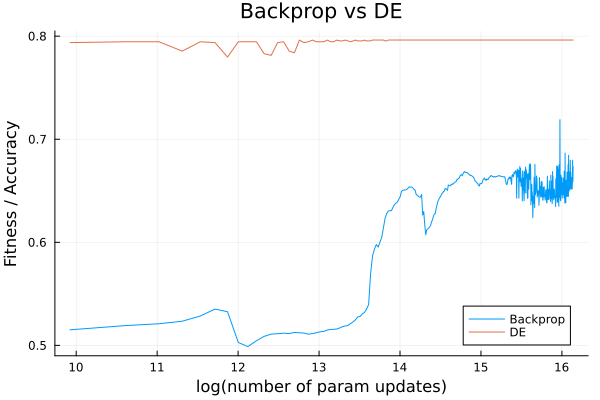

In [236]:
num_wt_updates = []
for i in 1:size(ns, 1)
    push!(num_wt_updates, log(ns[i]))
end
#Comparing Results
plot(num_wt_updates[1:500], [as Float32.(best_fitnesses)], title="Backprop vs DE", label=["Backprop" "DE"])
xlabel!("log(number of param updates)")
ylabel!("Fitness / Accuracy")